In [266]:
import h5py
import os
import pandas as pd
import numpy as np
import geopandas as gpd
os.chdir("C:\\Users\\llavin\\Desktop\\PRAS")


To-Do

- mapper of utilities to MISO areas
- once mapped, can do zonal EUE and LOLE fills
- heatplot of hourly lole
- how to look at ELCC?


In [267]:
#data loads
miso_map =  pd.read_excel(os.path.join(os.getcwd(), "NREL-Seams Model (MISO).xlsx"), sheet_name='Mapping')
miso_loads = pd.read_excel(os.path.join(os.getcwd(), "NREL-Seams Model (MISO).xlsx"), sheet_name='Load')

#results loads
region_lole = pd.read_csv(os.path.join(os.getcwd(),'regionlole.csv'),header=None)
region_eue = pd.read_csv(os.path.join(os.getcwd(),'regioneue.csv'),header=None)
region_period_eue = pd.read_csv(os.path.join(os.getcwd(),'regionperiodeue.csv'),header=None)
period_eue = pd.read_csv(os.path.join(os.getcwd(),'periodeue.csv'),header=None)
period_lolp = pd.read_csv(os.path.join(os.getcwd(),'periodlolp.csv'),header=None)
#clean some stuff
region_lole.index,region_eue.index = (list(miso_map['CEP Bus ID']),list(miso_map['CEP Bus ID']))
region_lole.columns,region_eue.columns = ['LOLE'],['EUE']

region_df = pd.concat([region_lole, region_eue], axis=1)

In [268]:
#additional joins to get a bit more info before plotting
tmps = len(region_period_eue.columns)

region_df['load']=list(miso_loads.iloc[:tmps,1:].sum(axis=0))
region_df['names'] = miso_map['CEP Bus Name'].values
region_df

,LOLE,EUE,load,names
2,0.00293,0.79073,2.914913e+07,AECIZ
3,0.00000,0.00000,6.515218e+07,ATC
7,1.50265,647.57043,4.565154e+06,CBPC-NIPCO
8,0.00000,0.00000,4.740742e+07,CONS
12,0.00000,0.00000,5.330881e+07,DECO
17,0.00000,0.00000,3.541566e+07,EES-ARK
18,0.10319,19.50022,2.207761e+07,EES-TX
21,0.00072,0.14353,2.759662e+07,IA-E
22,0.00000,0.00000,4.702684e+07,IL-C
23,0.00000,0.00000,3.772665e+07,IN-C


In [269]:
# 12x24 heatmap
import re

def format12x24(df,mean=False):
    df['Date'] = list(miso_loads['Date'])
    #for d in df['Date'].values:
    df['Month'] = [int(re.findall(r'-(\d+)-',str(d))[0]) for d in df['Date'].values]
    #print(df['Date'].values)
    df['HourBegin']=(df.index.values%24)
    #print(df)
    #print(df[0][(df.HourBegin==15) & (df.Month==7)].sum())
    #for i in df.index:
    #    if df.at[i,0]>0:
    #        print(df.loc[i,:])
    np_12x24 = np.zeros((12,24))
    for r in range(np_12x24.shape[0]):
        for c in range(np_12x24.shape[1]):
            #print(df[0][(df.Month==r+1) & (df.HourBegin==c)].sum())
            if mean:
                np_12x24[r,c] += df[0][(df.Month==r+1) & (df.HourBegin==c)].mean()
            else:
                np_12x24[r,c] += df[0][(df.Month==r+1) & (df.HourBegin==c)].sum()
    insert_row = np.zeros((1,24))
    np_12x24 = np.vstack((insert_row,np_12x24)) #helps to fix indexing
    return(np_12x24)
period_eue_np12x24 = format12x24(period_eue)
period_lolp_np12x24 = format12x24(period_lolp,mean=True)


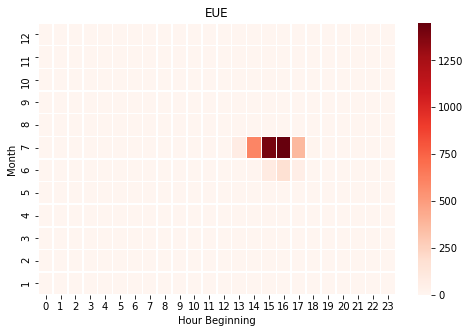

In [371]:
#plots
import seaborn as sns
fig, ax = plt.subplots(1, figsize=(8, 5))
ax = sns.heatmap(period_eue_np12x24, linewidth=0.5,cmap='Reds')
ax.set_ylim(1, 13) 
ax.set_ylabel('Month')
ax.set_xlabel('Hour Beginning')
ax.set_title('EUE')
plt.savefig("eueheatmap.jpg", dpi=300)
#plt.show()


In [271]:
os.chdir(os.environ['CONDA_PREFIX'] + r'\Library\share\gdal')
#must be in gdal folder specified above
iso_map = gpd.read_file(os.path.join(os.getcwd(),'Independent_System_Operators.shp'))
iso_map.to_crs(epsg=4326,inplace=True) #change coordinate system
states = gpd.read_file(os.path.join(os.getcwd(),'states.shp'))
utilities_map = gpd.read_file(os.path.join(os.getcwd(),'Retail_Service_Territories.shp'))
utilities_map.to_crs(epsg=4326,inplace=True)

os.chdir("C:\\Users\\llavin\\Desktop\\PRAS")

In [272]:
#sanbox for miso zone checking

In [359]:
# map from miso zones to utility territories

map_dict = {}
mo_coops = list(utilities_map[(utilities_map['STATE']=='MO') & (utilities_map['NAME'].str.contains('COOP'))]['NAME'])
map_dict['AECIZ'] = [mo_coops,'olive']
map_dict['ATC'] = [['WISCONSIN ELECTRIC POWER CO','WISCONSIN PUBLIC SERVICE CORP','WISCONSIN POWER & LIGHT CO'],'pink']
#ia_coops = list(utilities_map[(utilities_map['STATE']=='IA') & (utilities_map['NAME'].str.contains('COOP'))]['NAME'])
#map_dict['CBPC-NIPCO'] = [ia_coops,'k']
#cbpc co-ops: http://www.cbpower.coop/aspx/general/page.aspx?PageID=158
#nipco co-ops: https://www.nipco.coop/we-are-member-owned/our-members
nipco_coops = ['NORTH WEST RURAL ELECTRIC COOP','WOODBURY COUNTY RURAL E C A',
              'WESTERN IOWA POWER COOP','HARRISON COUNTY RRL ELEC COOP','NISHNABOTNA VALLEY R E C']
map_dict['CBPC-NIPCO'] = [['MIDLAND POWER COOP','IOWA LAKES ELECTRIC COOP',
                           'BUTLER COUNTY RURAL ELEC COOP - (IA)',
                          'BOONE VALLEY ELECTRIC COOP','FRANKLIN RURAL ELECTRIC COOP - (IA)',
                           'RACCOON VALLEY ELECTRIC COOPERATIVE','PRAIRIE ENERGY COOP',
                          'CALHOUN COUNTY ELEC COOP ASSN','GRUNDY COUNTY RURAL ELEC COOP',
                          'NORTH WEST RURAL ELECTRIC COOP','WOODBURY COUNTY RURAL E C A',
                          'WESTERN IOWA POWER COOP','HARRISON COUNTY RRL ELEC COOP',
                           'NISHNABOTNA VALLEY R E C','HEARTLAND POWER COOP'],'k']
map_dict['CONS'] = [['CONSUMERS ENERGY CO'],'orange']
map_dict['DECO'] = [['DTE ELECTRIC COMPANY'],'g']
map_dict['EES-ARK'] = [['ENTERGY ARKANSAS INC'],'r']
map_dict['EES-TX'] = [['ENTERGY TEXAS INC.'],'gold']
#map_dict['IA-E'] = [['INTERSTATE POWER AND LIGHT CO'],'purple']
#https://www.iowarec.org/iowa-co-ops/our-members
map_dict['IA-E'] = [['EASTERN IOWA LIGHT & POWER COOP','EAST-CENTRAL IOWA RURAL ELEC COOP',
                    'FARMERS ELECTRIC COOP, INC - (IA)','MAQUOKETA VALLEY RRL ELEC COOP',
                    'LINN COUNTY REC','ACCESS ENERGY COOP','T I P RURAL ELECTRIC COOP',
                    'CHARITON VALLEY ELEC COOP, INC','SOUTHERN IOWA ELEC COOP, INC',
                    'PELLA COOPERATIVE ELEC ASSN','SOUTHWEST IOWA RURAL ELEC COOP',
                    'CLARKE ELECTRIC COOP INC - (IA)','ALLAMAKEE-CLAYTON EL COOP, INC',
                    'GUTHRIE COUNTY RURAL E C A','CONSUMERS ENERGY',
                    'MIENERGY COOPERATIVE'],'purple']
#il_coops = list(utilities_map[(utilities_map['STATE']=='IL') & (utilities_map['NAME'].str.contains('COOP'))]['NAME'])
map_dict['IL-C'] = [['AMEREN ILLINOIS COMPANY'],'darkred']
map_dict['IN-C'] = [['INDIANAPOLIS POWER & LIGHT CO','INDIANA MICHIGAN POWER CO'],'lime']
map_dict['IN-S'] = [['DUKE ENERGY INDIANA, LLC','SOUTHERN INDIANA GAS & ELEC CO'],'indigo']
map_dict['LA-GULF'] = [['ENTERGY GULF STATES - LA LLC','ENTERGY NEW ORLEANS, LLC','SOUTH LOUISIANA ELEC COOP ASSN'],'darkviolet']
map_dict['LA-N'] = [['CLECO POWER LLC','SOUTHWEST LOUISIANA E M C','NORTHEAST LOUISIANA POWER COOP INC.','CLAIBORNE ELECTRIC COOP, INC'],'aquamarine']
map_dict['MEC'] = [['MIDAMERICAN ENERGY CO'],'darkgoldenrod']
map_dict['MISO-MO'] = [['UNION ELECTRIC CO - (MO)'],'lightgreen']
map_dict['MISO-MS'] = [['ENTERGY MISSISSIPPI INC','MISSISSIPPI POWER CO'],'royalblue']
mn_coops = list(utilities_map[(utilities_map['STATE']=='MN') & (utilities_map['NAME'].str.contains('COOP'))]['NAME'])
mn_coops.remove('MIENERGY COOPERATIVE')
#http://minnesota.maps.arcgis.com/apps/webappviewer/index.html?id=95ae13000e0b4d53a793423df1176514/
map_dict['MN-NE'] = [['LAKE COUNTRY POWER','EAST CENTRAL ENERGY',
                     'CONNEXUS ENERGY','FEDERATED RURAL ELECTRIC ASSN',
                     'SOUTH CENTRAL ELECTRIC ASSN','RUNESTONE ELECTRIC ASSN',
                     'ITASCA-MANTRAP CO-OP ELECTRICAL ASSN','SIOUX VALLEY SW ELEC COOP']+mn_coops,'midnightblue']
map_dict['MN-SE'] = [['NORTHERN STATES POWER CO - MINNESOTA','NORTHERN STATES POWER CO - WISCONSIN'],'tan']
map_dict['MN-C'] = [['OTTER TAIL POWER CO'],'salmon']
map_dict['NIPS'] = [['NORTHERN INDIANA PUB SERV CO'],'slategray']
map_dict['SIPC'] = [['SOUTHWESTERN ELECTRIC COOP INC - (IL)','SOUTHEASTERN IL ELEC COOP, INC','PRAIRIE POWER, INC'],'yellow']
map_dict['UPPC'] = [['UPPER PENINSULA POWER COMPANY','CLOVERLAND ELECTRIC CO-OP'],'cyan']

#grab zonal eues and lolps
for k in map_dict.keys():
    map_dict[k].append(region_df.EUE[region_df['names']==k].values[0])
    map_dict[k].append(region_df.LOLE[region_df['names']==k].values[0])

#miso_map
#map_dict

In [360]:
#create subset df and append eue
index_list = []
for k,v in map_dict.items():
    for utility in v[0]:
        index_list.append(utilities_map.index[utilities_map['NAME']==utility].values[0])
utilities_plot_df = utilities_map[utilities_map.index.isin(index_list)]

eue_list,lole_list = [],[]
for utility in utilities_plot_df['NAME']:
    for k,v in map_dict.items():
        for u in v[0]:
            if u==utility:
                eue_list.append(v[2])
                lole_list.append(v[3])
utilities_plot_df['eue'] = eue_list
utilities_plot_df['lole'] = lole_list
utilities_plot_df.head()

C:\Users\llavin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\llavin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,FID,ID,NAME,ADDRESS,CITY,STATE,ZIP,TELEPHONE,TYPE,COUNTRY,...,WSALE_MWH,TOTAL_MWH,TRANS_MWH,CUSTOMERS,YEAR,SHAPE_Leng,SHAPE_Area,geometry,eue,lole
126,127,814,ENTERGY ARKANSAS INC,425 WEST CAPITOL AVENUE,LITTLE ROCK,AR,72201,NOT AVAILABLE,INVESTOR OWNED,USA,...,8331076.0,31248886.0,0.0,708863.0,2017,2.846249e+06,1.725842e+11,"POLYGON ((-89.90988 35.54590, -89.91148 35.540...",0.00000,0.00000
486,487,12341,MIDAMERICAN ENERGY CO,666 GRAND AVENUE,DES MOINES,IA,50303,(888) 427-5632,INVESTOR OWNED,USA,...,9165323.0,34343004.0,0.0,770330.0,2017,4.027942e+06,1.276843e+11,"MULTIPOLYGON (((-93.25195 41.94100, -93.15075 ...",3473.33844,4.36402
487,488,9425,IOWA LAKES ELECTRIC COOP,702 SOUTH FIRST STREET,ESTHERVILLE,IA,51334,(712) 362-7870,COOPERATIVE,USA,...,38361.0,642428.0,0.0,12660.0,2017,7.227072e+05,1.927088e+10,"POLYGON ((-94.44295 43.27662, -94.44269 43.179...",647.57043,1.50265
488,489,12450,MIDLAND POWER COOP,1005 E. LINCOLNWAY,JEFFERSON,IA,50129,(515) 386-4111,COOPERATIVE,USA,...,25303.0,502631.0,0.0,11635.0,2017,8.841634e+05,1.652122e+10,"MULTIPOLYGON (((-93.47916 42.55747, -93.47907 ...",647.57043,1.50265
489,490,5605,EASTERN IOWA LIGHT & POWER COOP,EAST 5TH & SYCAMORE,WILTON,IA,52778,(563) 732-2211,COOPERATIVE,USA,...,25687.0,655671.0,0.0,23662.0,2017,8.565823e+05,1.567523e+10,"POLYGON ((-91.22795 41.66392, -91.22964 41.666...",0.14353,0.00072


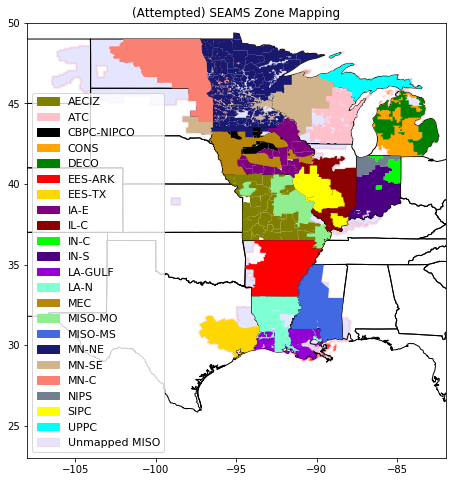

In [365]:
import matplotlib.pyplot as plt
import descartes
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, figsize=(8, 8))
myaxes = plt.axes()
myaxes.set_ylim([23, 50])
myaxes.set_xlim([-108,-82])
myaxes.set_title('(Attempted) SEAMS Zone Mapping')
iso_map[iso_map['NAME']==iso_map.at[0,'NAME']].plot(ax=myaxes,facecolor='b',edgecolor='r',alpha=0.1,linewidth=2)
states.plot(ax=myaxes,edgecolor='k',facecolor='None')

#IOUlabel = mpatches.Patch(color='red', label='IOU')
#munilabel = mpatches.Patch(color='green',label='Muni')
#coop = mpatches.Patch(color='blue',label='Coop')
leg_labels = []
for k,v in map_dict.items():
    leg_labels.append(mpatches.Patch(color=v[1],label=k))
leg_labels.append(mpatches.Patch(facecolor='b',edgecolor='r',alpha=0.1,label='Unmapped MISO'))
myaxes.legend(handles=leg_labels,fontsize=11,loc='lower left')


for k,v in map_dict.items():
    for utility in v[0]:
        utilities_map[utilities_map['NAME']==utility].plot(ax=myaxes,color=v[1],legend=True)
        #eventually also use key to label

plt.savefig("misomap.jpg", dpi=300)

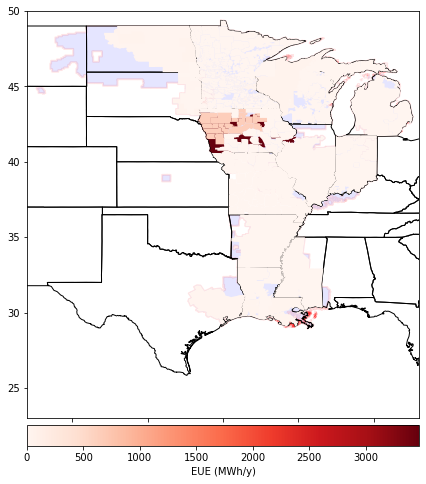

In [366]:
#plot eue
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize=(8, 8))
myaxes = plt.axes()
myaxes.set_ylim([23, 50])
myaxes.set_xlim([-108,-82])
iso_map[iso_map['NAME']==iso_map.at[0,'NAME']].plot(ax=myaxes,facecolor='b',edgecolor='r',alpha=0.1,linewidth=2)
states.plot(ax=myaxes,edgecolor='k',facecolor='None')

divider = make_axes_locatable(myaxes)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

utilities_plot_df.plot(ax=myaxes,column='eue',cmap='Reds',legend=True,cax=cax,
                      legend_kwds={'label': "EUE (MWh/y)",'orientation':"horizontal"})
plt.savefig("PRASMISOEUE.jpg", dpi=300)

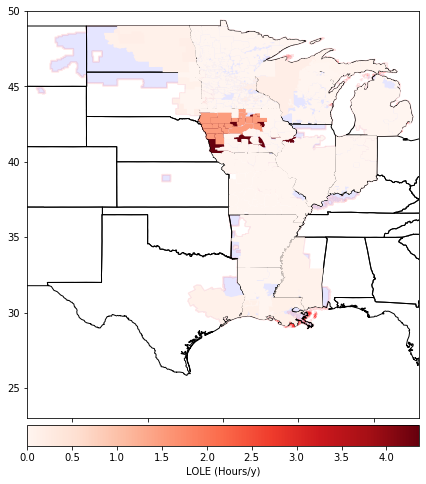

In [367]:
#same as above but lole
fig, ax = plt.subplots(1, figsize=(8, 8))
myaxes = plt.axes()
myaxes.set_ylim([23, 50])
myaxes.set_xlim([-108,-82])
iso_map[iso_map['NAME']==iso_map.at[0,'NAME']].plot(ax=myaxes,facecolor='b',edgecolor='r',alpha=0.1,linewidth=2)
states.plot(ax=myaxes,edgecolor='k',facecolor='None')

divider = make_axes_locatable(myaxes)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

utilities_plot_df.plot(ax=myaxes,column='lole',cmap='Reds',legend=True,cax=cax,
                      legend_kwds={'label': "LOLE (Hours/y)",'orientation':"horizontal"})
plt.savefig("PRASMISOLOLE.jpg", dpi=300)

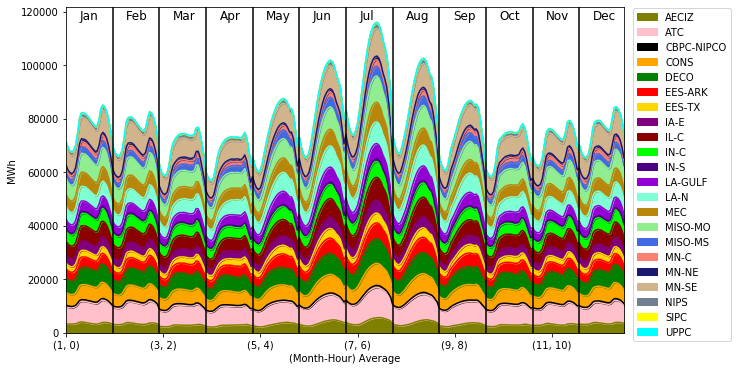

In [433]:
# additional figure to visualize zonal loads
from pylab import text
def aggregate_zones(df,tmps=24,monthly=False):
    if monthly==False:
        df = df.iloc[:,1:]
    else:
        df['Month'] = [int(re.findall(r'-(\d+)-',str(d))[0]) for d in df['Date'].values]
        df = df.iloc[:,1:]
    df['hour']= list(range(tmps))*int(len(df.index)/tmps)
    if monthly==False:
        df = df.groupby('hour').mean()
    else:
        df = df.groupby(['Month','hour']).mean()
        #print(df)
    return df
monthly=True
miso_loads_zones = aggregate_zones(miso_loads,monthly=monthly)

color_list = [map_dict[k][1] for k in miso_loads_zones.columns]

fig, ax = plt.subplots(1, figsize=(10, 6))
miso_loads_zones.plot.area(ax=ax,color=color_list)
#ax.set_ylim((0,))
ax.set_ylabel('MWh')
if monthly:
    ax.set_xlabel('(Month-Hour) Average')
else:
    ax.set_xlabel('Hour Beginning')
for index,label in enumerate(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']):
    plt.axvline(x=(index+1)*24,color='k')
    text((index+1)*24-17, 117000, label, fontsize=12)
# draw vertical line from (70,100) to (70, 250)
#plt.plot([24, 0], [24, 100000], 'k-', lw=2)

lgd = plt.legend(bbox_to_anchor=(1.2,1.01), loc="upper right")
plt.savefig("MISOload.jpg", bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=300)

In [396]:
miso_loads['']

,Date,AECIZ,ATC,CBPC-NIPCO,CONS,DECO,EES-ARK,EES-TX,IA-E,IL-C,...,LA-N,MEC,MISO-MO,MISO-MS,MN-C,MN-NE,MN-SE,NIPS,SIPC,UPPC
0,2012-01-01 00:00:00,2886.515863,5876.396062,477.446242,4267.752531,4799.012377,3104.387091,1935.229747,2572.234420,4254.461415,...,4246.388319,3875.036373,5148.050633,1927.822211,1540.465097,885.003373,6537.356707,1280.744238,42.484535,95.651883
1,2012-01-01 01:00:00,2740.609682,5634.925188,247.595699,4092.127650,4601.525299,2980.980673,1858.299982,2488.361555,4097.135661,...,4077.584766,3749.353916,4979.867795,1851.186912,1484.174214,852.476928,6298.850160,1251.088961,40.926698,91.715655
2,2012-01-01 02:00:00,2708.423070,5417.110013,247.345989,3933.338373,4422.969560,2925.200472,1823.527416,2443.226923,3969.954168,...,4001.284876,3682.871046,4888.148902,1816.547447,1443.490900,828.682464,6127.028066,1217.483160,39.649673,88.156757
3,2012-01-01 03:00:00,2678.466821,5273.156092,248.503370,3828.439185,4305.012275,2861.029847,1783.524382,2405.143375,3884.805803,...,3913.508002,3626.100788,4811.298880,1776.697533,1415.246651,812.288063,6007.378869,1183.432972,38.786271,85.805683
4,2012-01-01 04:00:00,2687.375519,5206.417886,251.641386,3780.001202,4250.544618,2805.591690,1748.965042,2393.658498,3853.631255,...,3837.675983,3609.997844,4789.060308,1742.270476,1397.526963,801.773843,5933.362117,1182.952927,38.480798,84.720056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2012-12-30 19:00:00,4312.384714,7649.771746,614.266644,5558.564194,6250.507304,4514.953255,2814.556172,3483.280412,5765.186938,...,6175.855073,5263.906315,6992.301875,2803.782812,1937.756155,1108.680916,8242.069356,1566.263954,57.401724,124.582466
8756,2012-12-30 20:00:00,4308.512082,7545.950867,617.305655,5481.954217,6164.360738,4561.756553,2843.732667,3456.583319,5736.811279,...,6239.875755,5221.549438,6937.165929,2832.847628,1941.105746,1111.201212,8252.980428,1563.979749,57.128371,122.865429
8757,2012-12-30 21:00:00,4227.129889,7292.587544,593.130209,5297.121273,5956.519355,4540.056779,2830.205344,3383.299598,5644.234046,...,6210.193352,5111.244083,6792.410927,2819.372083,1896.338040,1085.455586,8062.230548,1536.874245,56.210754,118.722823
8758,2012-12-30 22:00:00,4109.976679,6943.164536,583.301995,5041.993725,5669.632931,4421.710015,2756.429693,3262.787856,5484.861753,...,6048.310732,4928.009420,6551.599894,2745.878826,1839.395109,1053.211630,7817.554423,1511.340330,54.650192,113.004724
